<h1 style="color:rgb(0,120,170)">Hands-on AI II</h1>
<h2 style="color:rgb(0,120,170)">Unit 6 – Sentiment Analysis with BERT </h2>

<b>Authors:</b> N. Rekabsaz, B. Schäfl, S. Lehner, J. Brandstetter<br>
<b>Date:</b> May 2021

This file is part of the "Hands-on AI II" lecture material. The following copyright statement applies to all code within this file.

<b>Copyright statement:</b><br>
This  material,  no  matter  whether  in  printed  or  electronic  form,  may  be  used  for personal  and non-commercial educational use only.  Any reproduction of this manuscript, no matter whether as a whole or in parts, no matter whether in printed or in electronic form, requires explicit prior acceptance of the authors.

<h2>Table of contents</h2>
<ol>
    <a href="#bert"><li style="font-size:large;font-weight:bold">Model Training and Evaluation</li></a>
    <ol style="margin-bottom:15px">
        <a href="#bert-parameters"><li style="font-size:medium">Defining Parameters</li></a>
        <a href="#bert-tokenization"><li style="font-size:medium">WordPiece Tokenization</li></a>
        <a href="#bert-data"><li style="font-size:medium">Data Preparation</li></a>
        <a href="#bert-model"><li style="font-size:medium">Model Definition</li></a>
        <a href="#bert-training"><li style="font-size:medium">Training & Evaluation</li></a>
    </ol>
    <a href="#analysis"><li style="font-size:large;font-weight:bold">Analysis and Visualization</li></a>
</ol>


<h3 style="color:rgb(0,120,170)">How to use this notebook</h3>
<p><p>This notebook is designed to run from start to finish. There are different tasks (displayed in <span style="color:rgb(248,138,36)">orange boxes</span>) which might require small code modifications. Most/All of the used functions are imported from the file <code>U6_utils.py</code> which can be seen and treated as a black box. However, for further understanding, you can look at the implementations of the helper functions. In order to run this notebook, the packages which are imported at the beginning of <code>U6_utils.py</code> need to be installed.</p></p>

In [1]:
import U6_utils as u6

import sys
import os
import io
import pandas as pd
import numpy as np
import datetime
import time
import matplotlib.pyplot as plt
import ipdb

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix

import torch
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertModel, BertConfig

# Setup Jupyter notebook (warning: this may affect all Jupyter notebooks running on the same Jupyter server).
u6.setup_jupyter()

<h3 style="color:rgb(0,120,170)">Module versions</h3>
<p><p>As mentioned in the introductory slides, specific minimum versions of Python itself as well as of used modules is recommended.</p></p>

In [2]:
u6.check_module_versions()

Installed Python version: 3.9 (✓)
Installed numpy version: 1.20.2 (✓)
Installed pandas version: 1.2.4 (✓)
Installed matplotlib version: 3.4.2 (✓)
Installed PyTorch version: 1.8.1 (✓)
Installed scikit-learn version: 0.24.2 (✓)
Installed scipy version: 1.6.3 (✓)
Installed transformers_check version: 4.7.0 (✓)


<a name="bert"></a><h2>Model Training and Evaluation</h2>

<a name="bert-parameters"></a><h3 style="color:rgb(0,120,170)">Defining Parameters</h3>

In [3]:
## Data paths
TRAIN_DATA_PATH = "resources/sst5/train.txt"
VALIDATION_DATA_PATH = "resources/sst5/validation.txt"
TEST_DATA_PATH = "resources/sst5/test.txt"
LABEL_CAPTIONS_PATH = "resources/sst5/labels.txt"

## BERT parameters
BERT_PRETRAINED_MODEL_ID = 'google/bert_uncased_L-2_H-128_A-2' # name identifier of a pre-trained transformers model.
# google/bert_uncased_L-4_H-256_A-4
# bert-base-uncased

## other training parameters
MAX_DOC_LENGTH = 100
BATCH_SIZE = 5         #batch size
SAVE_PATH = 'model.pt'      #path to save the final model

In [4]:
## GPU
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
print("Device:", device)

Device: cpu


<a name="bert-tokenization"></a><h3 style="color:rgb(0,120,170)">WordPiece Tokenization</h3>
<p><p>Tokenization is based on WordPiece - the default tokenizer of BERT.</p></p>

`convert_text_bertids_tensor` processes the texts of a given batch and provides the following tensors:
- `input_ids`: the subwordIDs achieved from tokenization and mapping subwords to their identifiers.
- `attention_mask`: specifies the active words in the batch.
- `token_type_ids`: the identifiers of the corresponding sentence for sentence embedding, when there are more than one consequent sentences.

<a name="tasks-one"></a><h3 style="color:rgb(0,120,170)">Tasks</h3>
    <div class="alert alert-warning">
        Execute the notebook until here and try to solve the following tasks:
        <ul>
            <li>Select 20 English words and tokenize them using WordPiece. Particularly, select several linguistically or syntactically "complicated" words that (in your opinion) should be splited into subwords. Report your observations regarding the tokenization results. What is expected and what is surprising (from your point of view) in these observations?</li>
            <li>Look into the documentation of the `BertTokenizer` class in the `huggingface` library. The created tokenizer from this class should contain a dictionary, responsible for converting subwords to subwordIDs and reverse. Find the provided way to access this dictionary (whether directly or through some functions). Map a sample text to ids using `u6.convert_text_bertids_tensor`, and then convert back the input_ids to their subwords. Compare the initial text and the result one. Are they exactly the same? What is the difference? Why?</li>
        </ul>
</div>

In [5]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [6]:
# sample WordPiece tokenization
_sample_text = "Aberration Abnegation Pleonasm Accommodation Irregardless Anachronistic Imagination Sesquipedalianism Uncopyrightable Euouae Consequences Infinitesimal Preposterous Contempible Minuscule Nonplussed Disinterested Enormity Ephemeral Nauseous"
print (tokenizer.tokenize(_sample_text))

#I see that words with the same ending are cuted into 2 but not always, some of the worlds from the beginnig are not cuted

['abe', '##rra', '##tion', 'ab', '##ne', '##gation', 'pl', '##eon', '##as', '##m', 'accommodation', 'ir', '##re', '##gard', '##less', 'ana', '##ch', '##ron', '##istic', 'imagination', 'se', '##s', '##qui', '##ped', '##alia', '##nism', 'un', '##co', '##py', '##right', '##able', 'eu', '##ou', '##ae', 'consequences', 'infinite', '##si', '##mal', 'prep', '##ost', '##ero', '##us', 'con', '##tem', '##pi', '##ble', 'minus', '##cule', 'non', '##pl', '##uss', '##ed', 'di', '##sin', '##ter', '##ested', 'en', '##or', '##mity', 'ep', '##hem', '##eral', 'na', '##use', '##ous']


In [7]:
_sample_batch_bertids=u6.convert_text_bertids_tensor(_sample_text,tokenizer,MAX_DOC_LENGTH)
decoded=tokenizer.batch_decode(_sample_batch_bertids['input_ids'])
print(decoded)

['[CLS] aberration abnegation pleonasm accommodation irregardless anachronistic imagination sesquipedalianism uncopyrightable euouae consequences infinitesimal preposterous contempible minuscule nonplussed disinterested enormity ephemeral nauseous [SEP]']


In [8]:
tokenize=tokenizer.tokenize(_sample_text)
to_ids=tokenizer.convert_tokens_to_ids(tokenize)
to_tok=tokenizer.convert_ids_to_tokens(to_ids)
print(to_ids)
print(to_tok==tokenize)

[14863, 11335, 3508, 11113, 2638, 12540, 20228, 10242, 3022, 2213, 11366, 20868, 2890, 13444, 3238, 9617, 2818, 4948, 6553, 9647, 7367, 2015, 15549, 5669, 22786, 28113, 4895, 3597, 7685, 15950, 3085, 7327, 7140, 6679, 8465, 10709, 5332, 9067, 17463, 14122, 10624, 2271, 9530, 18532, 8197, 3468, 15718, 21225, 2512, 24759, 17854, 2098, 4487, 11493, 3334, 17944, 4372, 2953, 16383, 4958, 29122, 21673, 6583, 8557, 3560]
True


In [9]:
# sample convert_text_bertids_tensor

_sample_batch_bertids = u6.convert_text_bertids_tensor(_sample_text, tokenizer, MAX_DOC_LENGTH)
ids=_sample_batch_bertids['input_ids']
subwords=tokenizer.convert_ids_to_tokens(ids[0,:])
print(tokenize)
print(subwords)





['abe', '##rra', '##tion', 'ab', '##ne', '##gation', 'pl', '##eon', '##as', '##m', 'accommodation', 'ir', '##re', '##gard', '##less', 'ana', '##ch', '##ron', '##istic', 'imagination', 'se', '##s', '##qui', '##ped', '##alia', '##nism', 'un', '##co', '##py', '##right', '##able', 'eu', '##ou', '##ae', 'consequences', 'infinite', '##si', '##mal', 'prep', '##ost', '##ero', '##us', 'con', '##tem', '##pi', '##ble', 'minus', '##cule', 'non', '##pl', '##uss', '##ed', 'di', '##sin', '##ter', '##ested', 'en', '##or', '##mity', 'ep', '##hem', '##eral', 'na', '##use', '##ous']
['[CLS]', 'abe', '##rra', '##tion', 'ab', '##ne', '##gation', 'pl', '##eon', '##as', '##m', 'accommodation', 'ir', '##re', '##gard', '##less', 'ana', '##ch', '##ron', '##istic', 'imagination', 'se', '##s', '##qui', '##ped', '##alia', '##nism', 'un', '##co', '##py', '##right', '##able', 'eu', '##ou', '##ae', 'consequences', 'infinite', '##si', '##mal', 'prep', '##ost', '##ero', '##us', 'con', '##tem', '##pi', '##ble', 'minus',

<a name="bert-data"></a><h3 style="color:rgb(0,120,170)">Data Preperation</h3>
<p><p>
The train/val/test dataset corpora are loaded and their texts are converted to the required tensors.</p></p>

<a name="tasks-one"></a><h3 style="color:rgb(0,120,170)">Tasks</h3>
    <div class="alert alert-warning">
        Execute the notebook until here and try to solve the following tasks:
        <ul>
            <li>Explain how the size of the batches is specified? Why is the batch size of train dataset different from the one of test dataset?</li>
        </ul>
</div>

In [10]:
df_train = u6.load_dataset(TRAIN_DATA_PATH) 
df_val = u6.load_dataset(VALIDATION_DATA_PATH)
df_test = u6.load_dataset(TEST_DATA_PATH)

print (df_train.head())

print ()
print ('Train dataset size:', len(df_train.index))
print ('Validation dataset size:', len(df_val.index))
print ('Test dataset size:', len(df_test.index))

   sentence_id                                               text  label
0         2717  From a deceptively simple premise , this deepl...      4
1         4070  A static and sugary little half-hour , after-s...      2
2        11031  It 's a trifle of a movie , with a few laughs ...      2
3         2008  If you can push on through the slow spots , yo...      3
4         7845  Stealing Harvard will dip into your wallet , s...      0

Train dataset size: 7106
Validation dataset size: 2369
Test dataset size: 2369


In [11]:
labelcaptions = u6.load_captions(LABEL_CAPTIONS_PATH)

print (labelcaptions)

{'very negative': 0, 'negative': 1, 'neutral': 2, 'positive': 3, 'very positive': 4}


In [12]:
def get_document_label_tensor(df_data):
    documents = []
    for x in df_data['text'].values:
        documents.append(x.strip())
    labels = np.array(list(df_data['label'].values))
    data = u6.convert_text_bertids_tensor(documents, tokenizer, MAX_DOC_LENGTH)
    
    return data, labels

x_train, y_train = get_document_label_tensor(df_train)
print ('Train data items:', str(x_train['input_ids'].shape))
print ('Train labels:', str(y_train.shape))

x_val, y_val = get_document_label_tensor(df_val)
print ('Validation data items:', str(x_val['input_ids'].shape))
print ('Validation labels:', str(y_val.shape))

x_test, y_test = get_document_label_tensor(df_test)
print ('Test data items:', str(x_test['input_ids'].shape))
print ('Test labels:', str(y_test.shape))


Train data items: torch.Size([7106, 66])
Train labels: (7106,)
Validation data items: torch.Size([2369, 66])
Validation labels: (2369,)
Test data items: torch.Size([2369, 60])
Test labels: (2369,)


In [13]:
print ('x_train: %s' % x_train)
print ()
print ('y_train: %s' % y_train)

x_train: {'input_ids': tensor([[  101,  2013,  1037,  ...,     0,     0,     0],
        [  101,  1037, 10763,  ...,     0,     0,     0],
        [  101,  2009,  1005,  ...,     0,     0,     0],
        ...,
        [  101,  4983,  2017,  ...,     0,     0,     0],
        [  101,  1996, 11350,  ...,     0,     0,     0],
        [  101,  2009,  1005,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

y_train: [4 2 2 ... 1 2 2]


<a name="bert-model"></a><h3 style="color:rgb(0,120,170)">Model Definition</h3>

The classification model is in fact a pretrained BERT model. The input to the model must have the `[CLS]` token at the beginning and `[SEP]`at the end. The corresponding output of `[CLS]` is counted as the sentence embedding, used for predicting the class/sentiment of the text. The overall scheme of the model is shown below:


<div>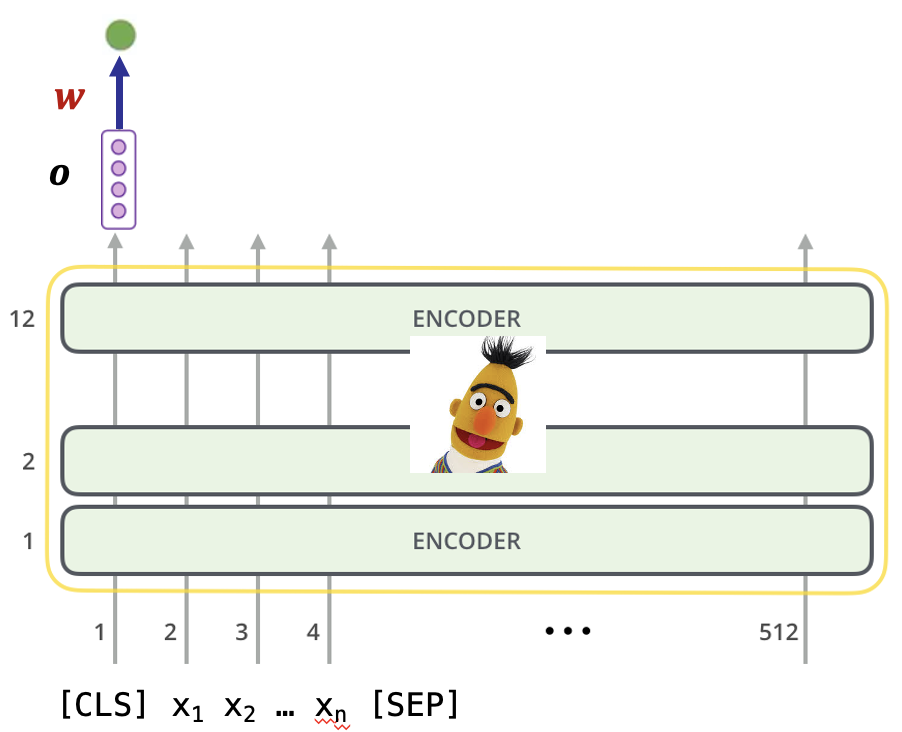</div>


In [25]:
class BERTClassifierModel(torch.nn.Module):
    '''
    Classification model with BERT
    '''
    def __init__(self, bert, nout):
        super(BERTClassifierModel, self).__init__()
        
        self.bert = bert
        self.embedding_size = self.bert.config.hidden_size 

        self.output_projection_layer = torch.nn.Linear(self.embedding_size, nout)

    '''
    input format: seq_len, batch
    '''
    def forward(self, input_batch):
        #ipdb.set_trace()
        out = self.bert(input_ids=input_batch['input_ids'], 
                        attention_mask=input_batch['attention_mask'], 
                        token_type_ids=input_batch['token_type_ids'],
                        return_dict=True)
        
        hiddens = out["last_hidden_state"][:,0,:]
        
        logits = self.output_projection_layer(hiddens)
        yhat_logprobs = torch.nn.LogSoftmax(dim=-1)(logits)
        
        return yhat_logprobs, hiddens
    

In [26]:
bert = BertModel.from_pretrained(BERT_PRETRAINED_MODEL_ID, cache_dir="cache")

model = BERTClassifierModel(bert=bert, nout=len(labelcaptions.keys()))
model.to(device)
print('Model:', model)

print('Model total parameters: %s' % sum(p.numel() for p in model.parameters()))
print('Model total trainable parameters: %s' % sum(p.numel() for p in model.parameters() if p.requires_grad))


Some weights of the model checkpoint at google/bert_uncased_L-2_H-128_A-2 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model: BERTClassifierModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=128, out_features=128, bias=True)
              (LayerNorm): LayerNorm((128,), eps=1e-12, elementwis

In [16]:
# dataloaders 
dataset_train = TensorDataset(x_train['input_ids'], x_train['token_type_ids'], x_train['attention_mask'], torch.LongTensor(y_train))
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=1, drop_last=True)

dataset_val = TensorDataset(x_val['input_ids'], x_val['token_type_ids'], x_val['attention_mask'], torch.LongTensor(y_val))
dataloader_val = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=True, num_workers=1, drop_last=True)

dataset_test = TensorDataset(x_test['input_ids'], x_test['token_type_ids'], x_test['attention_mask'], torch.LongTensor(y_test))
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True, num_workers=1, drop_last=True)



<a name="bert-training"></a><h3 style="color:rgb(0,120,170)">Training and Evaluation</h3>
<p><p></p></p>

This section contains the code of training the model and evaluating the validation set. Performance is evaluated with accuracy. Descriptions are provided as comments inside the code.

<a name="tasks-one"></a><h3 style="color:rgb(0,120,170)">Tasks</h3>
    <div class="alert alert-warning">
        Execute the notebook until here and try to solve the following tasks:
        <ul>
            <li>Using *ipdb*, look inside the forward function during training. In particular, trace the variables `out`, `hiddens`, `logits`, and `yhat_logprobs`. Report the shape of each of these variables and explain what they should contain.
            </li>
            <li>Train the model with over all samples with many epochs (at least 20).
        </ul>
</div>

In [17]:
#used for tracing
EPOCHS = 20           #maximum number of epochs
MAX_NUMBER_BATCHES_TRAIN = -1 # only for the sake of debugging. Set to -1 to be ignored
MAX_NUMBER_BATCHES_PREDICT = -1 # only for the sake of debugging. Set to -1 to be ignored

## log parameters
LOG_INTERVAL_TRAIN = 100     #log interval during training
LOG_INTERVAL_PREDICT = 100 #log interval during validation


def predict(dataloader, model):
    # Turn on evaluation mode which disables dropout.
    model.eval()
    _yhat_all = []
    _y_all = []
    _hiddens_all = []
    for i, batch in enumerate(dataloader):
        _input_ids, _token_type_ids, _attention_mask, _y = batch
        _input_batch = {'input_ids': _input_ids,
                        'token_type_ids': _token_type_ids, 
                        'attention_mask': _attention_mask}
        
        with torch.no_grad():
            _yhat_logprobs, _hiddens = model.forward(_input_batch)
            _yhat = torch.argmax(_yhat_logprobs, dim=1)
        _yhat_all.extend(_yhat.numpy())
        _y_all.extend(_y.numpy())
        _hiddens_all.extend(_hiddens.numpy())
        
        if i % LOG_INTERVAL_PREDICT == 0 and i > 0:
            print('Prediction | %5d batches | %5d data |' % (i, i*BATCH_SIZE))
            
        if (i > MAX_NUMBER_BATCHES_PREDICT) and (MAX_NUMBER_BATCHES_PREDICT != -1):
            break
            
    return _yhat_all, _y_all, np.array(_hiddens_all)

def train(dataloader, model):
    # Turn on training mode which enables dropout.
    model.train()
    start_time = time.time()
    log_interval_loss = 0
    for i, batch in enumerate(dataloader):
        _input_ids, _token_type_ids, _attention_mask, _y = batch
        _input_batch = {'input_ids': _input_ids,
                        'token_type_ids': _token_type_ids, 
                        'attention_mask': _attention_mask}
        
        ipdb.set_trace()
        
        optimizer.zero_grad()
        
        _yhat_logprobs, _ = model.forward(_input_batch)

        loss = torch.nn.NLLLoss()(_yhat_logprobs, _y)
        loss.backward()
        if CLIP: 
            torch.nn.utils.clip_grad_norm_(list(model.parameters()), CLIP)
        
        optimizer.step()
        
        log_interval_loss += loss.item()
        if i % LOG_INTERVAL_TRAIN == 0 and i > 0:
            cur_loss = log_interval_loss / LOG_INTERVAL_TRAIN
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d} batches | {:5d} data | ms/batch {:5.2f} | loss {:.4f}'.
                  format(epoch, i, i*BATCH_SIZE, elapsed * 1000 / LOG_INTERVAL_TRAIN, cur_loss))
            log_interval_loss = 0
            start_time = time.time()
            
        if (i > MAX_NUMBER_BATCHES_TRAIN) and (MAX_NUMBER_BATCHES_TRAIN != -1):
            break

print('=' * 89)
print('Start training')

EVAL_MEASURE = 'accuracy'
CLIP = 0.25            #gradient clipping
LEARNING_RATE = 0.00003     #initial learning rate
WEIGHT_DECAY = 1.2e-6       #weight decay applied to all weights

optimizer = torch.optim.Adam(list(model.parameters()), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Loop over epochs.
best_val_res = []
stored_res = 100000000
for epoch in range(1, EPOCHS+1):
    epoch_start_time = time.time()
    train(dataloader_train, model)

    print('Epoch %d validation' % epoch)
    _yhat_val, _labels_val, _ = predict(dataloader_val, model)
    val_results = classification_report(_labels_val, _yhat_val, output_dict=True)
    val_res = val_results[EVAL_MEASURE]
    
    print('-' * 89)
    print('| end of epoch %3d | time: %5.2fs | validation %s %.3f | ' % 
          (epoch, (time.time() - epoch_start_time), EVAL_MEASURE, val_res))
    print('-' * 89)

    if val_res < stored_res:
        u6.model_save(SAVE_PATH, model, optimizer)
        print('Saving model (new best validation)')
        stored_res = val_res

    best_val_res.append(val_res)
print('End of training')


Start training
> <ipython-input-17-90c9950cb2d6>(51)train()
     50 
---> 51         optimizer.zero_grad()
     52 

ipdb> n
> <ipython-input-17-90c9950cb2d6>(53)train()
     52 
---> 53         _yhat_logprobs, _ = model.forward(_input_batch)
     54 

ipdb> n
> <ipython-input-14-2d933d5457e4>(18)forward()
     17         ipdb.set_trace()
---> 18         out = self.bert(input_ids=input_batch['input_ids'], 
     19                         attention_mask=input_batch['attention_mask'],

ipdb> out = self.bert(input_ids=input_batch['input_ids'],                          attention_mask=input_batch['attention_mask'],                          token_type_ids=input_batch['token_type_ids'],                         return_dict=True)
ipdb> out['last_hidden_state'].shape
torch.Size([5, 66, 128])
ipdb> hiddens = out['last_hidden_state'][:,0,:]
ipdb> hiddens.shape
torch.Size([5, 128])
ipdb> logits = self,output_projection_layer(hiddens)
*** NameError: name 'output_projection_layer' is not defined
ipdb

BdbQuit: 

In [27]:
EPOCHS = 20           #maximum number of epochs
MAX_NUMBER_BATCHES_TRAIN = -1 # only for the sake of debugging. Set to -1 to be ignored
MAX_NUMBER_BATCHES_PREDICT = -1 # only for the sake of debugging. Set to -1 to be ignored

## log parameters
LOG_INTERVAL_TRAIN = 100     #log interval during training
LOG_INTERVAL_PREDICT = 100 #log interval during validation


def predict(dataloader, model):
    # Turn on evaluation mode which disables dropout.
    model.eval()
    _yhat_all = []
    _y_all = []
    _hiddens_all = []
    for i, batch in enumerate(dataloader):
        _input_ids, _token_type_ids, _attention_mask, _y = batch
        _input_batch = {'input_ids': _input_ids,
                        'token_type_ids': _token_type_ids, 
                        'attention_mask': _attention_mask}
        
        with torch.no_grad():
            _yhat_logprobs, _hiddens = model.forward(_input_batch)
            _yhat = torch.argmax(_yhat_logprobs, dim=1)
        _yhat_all.extend(_yhat.numpy())
        _y_all.extend(_y.numpy())
        _hiddens_all.extend(_hiddens.numpy())
        
        if i % LOG_INTERVAL_PREDICT == 0 and i > 0:
            print('Prediction | %5d batches | %5d data |' % (i, i*BATCH_SIZE))
            
        if (i > MAX_NUMBER_BATCHES_PREDICT) and (MAX_NUMBER_BATCHES_PREDICT != -1):
            break
            
    return _yhat_all, _y_all, np.array(_hiddens_all)

def train(dataloader, model):
    # Turn on training mode which enables dropout.
    model.train()
    start_time = time.time()
    log_interval_loss = 0
    for i, batch in enumerate(dataloader):
        _input_ids, _token_type_ids, _attention_mask, _y = batch
        _input_batch = {'input_ids': _input_ids,
                        'token_type_ids': _token_type_ids, 
                        'attention_mask': _attention_mask}
        
        #ipdb.set_trace()
        
        optimizer.zero_grad()
        
        _yhat_logprobs, _ = model.forward(_input_batch)

        loss = torch.nn.NLLLoss()(_yhat_logprobs, _y)
        loss.backward()
        if CLIP: 
            torch.nn.utils.clip_grad_norm_(list(model.parameters()), CLIP)
        
        optimizer.step()
        
        log_interval_loss += loss.item()
        if i % LOG_INTERVAL_TRAIN == 0 and i > 0:
            cur_loss = log_interval_loss / LOG_INTERVAL_TRAIN
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d} batches | {:5d} data | ms/batch {:5.2f} | loss {:.4f}'.
                  format(epoch, i, i*BATCH_SIZE, elapsed * 1000 / LOG_INTERVAL_TRAIN, cur_loss))
            log_interval_loss = 0
            start_time = time.time()
            
        if (i > MAX_NUMBER_BATCHES_TRAIN) and (MAX_NUMBER_BATCHES_TRAIN != -1):
            break

print('=' * 89)
print('Start training')

EVAL_MEASURE = 'accuracy'
CLIP = 0.25            #gradient clipping
LEARNING_RATE = 0.00003     #initial learning rate
WEIGHT_DECAY = 1.2e-6       #weight decay applied to all weights

optimizer = torch.optim.Adam(list(model.parameters()), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Loop over epochs.
best_val_res = []
stored_res = 100000000
for epoch in range(1, EPOCHS+1):
    epoch_start_time = time.time()
    train(dataloader_train, model)

    print('Epoch %d validation' % epoch)
    _yhat_val, _labels_val, _ = predict(dataloader_val, model)
    val_results = classification_report(_labels_val, _yhat_val, output_dict=True)
    val_res = val_results[EVAL_MEASURE]
    
    print('-' * 89)
    print('| end of epoch %3d | time: %5.2fs | validation %s %.3f | ' % 
          (epoch, (time.time() - epoch_start_time), EVAL_MEASURE, val_res))
    print('-' * 89)

    if val_res < stored_res:
        u6.model_save(SAVE_PATH, model, optimizer)
        print('Saving model (new best validation)')
        stored_res = val_res

    best_val_res.append(val_res)
print('End of training')

Start training
| epoch   1 |   100 batches |   500 data | ms/batch 70.54 | loss 1.6304
| epoch   1 |   200 batches |  1000 data | ms/batch 59.56 | loss 1.5964
| epoch   1 |   300 batches |  1500 data | ms/batch 60.29 | loss 1.5468
| epoch   1 |   400 batches |  2000 data | ms/batch 64.20 | loss 1.5734
| epoch   1 |   500 batches |  2500 data | ms/batch 64.55 | loss 1.5489
| epoch   1 |   600 batches |  3000 data | ms/batch 65.14 | loss 1.5816
| epoch   1 |   700 batches |  3500 data | ms/batch 65.32 | loss 1.5360
| epoch   1 |   800 batches |  4000 data | ms/batch 66.27 | loss 1.5624
| epoch   1 |   900 batches |  4500 data | ms/batch 67.44 | loss 1.5314
| epoch   1 |  1000 batches |  5000 data | ms/batch 66.13 | loss 1.5065
| epoch   1 |  1100 batches |  5500 data | ms/batch 71.11 | loss 1.4905
| epoch   1 |  1200 batches |  6000 data | ms/batch 68.68 | loss 1.4569
| epoch   1 |  1300 batches |  6500 data | ms/batch 66.63 | loss 1.5048
| epoch   1 |  1400 batches |  7000 data | ms/bat

C:\Users\stank\anaconda3\envs\my-rdkit-env\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\stank\anaconda3\envs\my-rdkit-env\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\stank\anaconda3\envs\my-rdkit-env\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 99.10s | validation accuracy 0.337 | 
-----------------------------------------------------------------------------------------
Saving model (new best validation)
| epoch   2 |   100 batches |   500 data | ms/batch 79.15 | loss 1.4478
| epoch   2 |   200 batches |  1000 data | ms/batch 69.14 | loss 1.4142
| epoch   2 |   300 batches |  1500 data | ms/batch 68.07 | loss 1.4159
| epoch   2 |   400 batches |  2000 data | ms/batch 67.38 | loss 1.3805
| epoch   2 |   500 batches |  2500 data | ms/batch 68.04 | loss 1.4086
| epoch   2 |   600 batches |  3000 data | ms/batch 68.81 | loss 1.3627
| epoch   2 |   700 batches |  3500 data | ms/batch 66.86 | loss 1.3512
| epoch   2 |   800 batches |  4000 data | ms/batch 67.94 | loss 1.3757
| epoch   2 |   900 batches |  4500 data | ms/batch 67.98 | loss 1.3716
| epoch   2 |  1000 batches |  5000 data | ms/batch 71.13 | loss 1.3938


| epoch   7 |  1100 batches |  5500 data | ms/batch 77.23 | loss 0.7562
| epoch   7 |  1200 batches |  6000 data | ms/batch 79.08 | loss 0.7902
| epoch   7 |  1300 batches |  6500 data | ms/batch 79.14 | loss 0.7964
| epoch   7 |  1400 batches |  7000 data | ms/batch 77.45 | loss 0.8199
Epoch 7 validation
Prediction |   100 batches |   500 data |
Prediction |   200 batches |  1000 data |
Prediction |   300 batches |  1500 data |
Prediction |   400 batches |  2000 data |
-----------------------------------------------------------------------------------------
| end of epoch   7 | time: 117.67s | validation accuracy 0.411 | 
-----------------------------------------------------------------------------------------
| epoch   8 |   100 batches |   500 data | ms/batch 87.61 | loss 0.6874
| epoch   8 |   200 batches |  1000 data | ms/batch 76.26 | loss 0.6905
| epoch   8 |   300 batches |  1500 data | ms/batch 79.16 | loss 0.6814
| epoch   8 |   400 batches |  2000 data | ms/batch 76.31 | los

| epoch  13 |   500 batches |  2500 data | ms/batch 104.07 | loss 0.3642
| epoch  13 |   600 batches |  3000 data | ms/batch 97.65 | loss 0.3807
| epoch  13 |   700 batches |  3500 data | ms/batch 100.27 | loss 0.3806
| epoch  13 |   800 batches |  4000 data | ms/batch 100.65 | loss 0.4500
| epoch  13 |   900 batches |  4500 data | ms/batch 103.82 | loss 0.3702
| epoch  13 |  1000 batches |  5000 data | ms/batch 104.39 | loss 0.3774
| epoch  13 |  1100 batches |  5500 data | ms/batch 107.00 | loss 0.4229
| epoch  13 |  1200 batches |  6000 data | ms/batch 107.51 | loss 0.3959
| epoch  13 |  1300 batches |  6500 data | ms/batch 110.00 | loss 0.3332
| epoch  13 |  1400 batches |  7000 data | ms/batch 110.66 | loss 0.3894
Epoch 13 validation
Prediction |   100 batches |   500 data |
Prediction |   200 batches |  1000 data |
Prediction |   300 batches |  1500 data |
Prediction |   400 batches |  2000 data |
-----------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------
| end of epoch  18 | time: 389.32s | validation accuracy 0.366 | 
-----------------------------------------------------------------------------------------
| epoch  19 |   100 batches |   500 data | ms/batch 289.44 | loss 0.2221
| epoch  19 |   200 batches |  1000 data | ms/batch 280.37 | loss 0.2924
| epoch  19 |   300 batches |  1500 data | ms/batch 281.38 | loss 0.2685
| epoch  19 |   400 batches |  2000 data | ms/batch 280.38 | loss 0.3133
| epoch  19 |   500 batches |  2500 data | ms/batch 281.08 | loss 0.1986
| epoch  19 |   600 batches |  3000 data | ms/batch 282.76 | loss 0.2226
| epoch  19 |   700 batches |  3500 data | ms/batch 281.14 | loss 0.2555
| epoch  19 |   800 batches |  4000 data | ms/batch 283.48 | loss 0.3068
| epoch  19 |   900 batches |  4500 data | ms/batch 283.83 | loss 0.2925
| epoch  19 |  1000 batches |  5000 data | ms/batch 283.38 | loss 0.2648
| epoch  19 |  1100 batc

In [28]:
# Load the best saved model.
model_state, optimizer_state = u6.model_load(SAVE_PATH)
model.load_state_dict(model_state)
optimizer.load_state_dict(optimizer_state)

# Run on test data.
_yhat_test, _y_test, _hiddens_test = predict(dataloader_test, model)
results = classification_report(_y_test, _yhat_test, output_dict=True)
print (classification_report(_y_test, _yhat_test))    

print('=' * 89)
print('| End of testing | test %s %.3f ' % (EVAL_MEASURE, results[EVAL_MEASURE]))
print('=' * 89)

Prediction |   100 batches |   500 data |
Prediction |   200 batches |  1000 data |
Prediction |   300 batches |  1500 data |
Prediction |   400 batches |  2000 data |
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       296
           1       0.43      0.35      0.38       599
           2       0.27      0.20      0.23       472
           3       0.34      0.70      0.46       641
           4       0.52      0.27      0.35       357

    accuracy                           0.36      2365
   macro avg       0.31      0.30      0.28      2365
weighted avg       0.33      0.36      0.32      2365

| End of testing | test accuracy 0.360 


C:\Users\stank\anaconda3\envs\my-rdkit-env\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\stank\anaconda3\envs\my-rdkit-env\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\stank\anaconda3\envs\my-rdkit-env\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C

The shape of out['last_hidden_state'] is torch.Size([5, 66, 128]) because 66 is len of list of token ids, the batch size is 5 and 128 is dimensionality of embedding vector, as specified in the bert model. 'Hiddens' has a shape of [5,128] becasue it refers to the embedding of CLS tokens, the sentence embedding for each sentence in batch. Then logits project this 'hiddens' to a 5 dimensional space for each sentence in batch. 5 here represent the number of classes we are interested in. yhat_logprobs has the same shape as logits because it simply applies log softmax to the last dimension (the one with 5 classes).

<a name="analysis"></a><h2>Analysis and Visualization</h2>

<a name="tasks-one"></a><h3 style="color:rgb(0,120,170)">Tasks</h3>
    <div class="alert alert-warning">
        Execute the notebook until here and try to solve the following tasks:
        <ul>
            <li>Beside the two provided plots, add a new one that shows the correctly and incorrectly classified datapoints. Similar to the other two plots, the new plot contains a point for each datapoint in the test set. If a datapoint is predicted correctly, the corresponding color of it is green, and otherwise red. Depict this plot by side with the other two plots. Look at the results and particularly the areas with clusters of red points in the newly created plot. Can you achieve a specific conclusion regarding the incorrectly classified datapoints? Report your observations and results.</li>
        </ul>
</div>

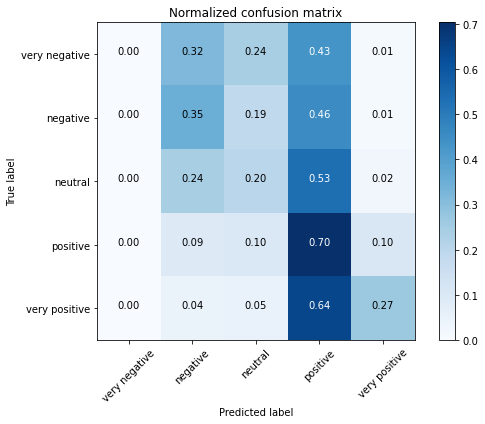

In [29]:
#code from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range (cm.shape[0]):
        for j in range (cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

tuples=[(key, value) for key, value in labelcaptions.items()]
tuples.sort(key=lambda x: x[1])
labelcaptions_inorder = [t[0] for t in tuples]

# Compute confusion matrix
cnf_matrix = confusion_matrix(_y_test, _yhat_test)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
#plt.figure(figsize=(8,6))
#plot_confusion_matrix(cnf_matrix, classes=labelcaptions_inorder,
#                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=labelcaptions_inorder, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [43]:
# Projecting sentence embeddings to 2 dimensions using TSNE

vis_model = TSNE(n_components=2, random_state=28)
projected_vectors = vis_model.fit_transform(_hiddens_test)

In [ ]:
c_list = [

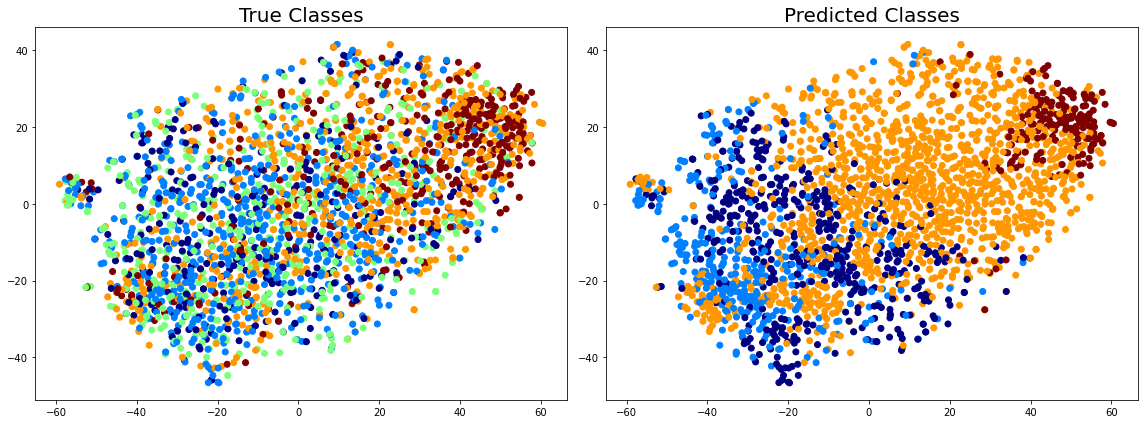

In [44]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

axes[0].scatter(projected_vectors[:, 0], projected_vectors[:, 1], c=_y_test, 
                cmap=plt.cm.get_cmap("jet", np.max(_y_test)+1))
axes[0].set_title("True Classes", fontsize=20)

axes[1].scatter(projected_vectors[:, 0], projected_vectors[:, 1], c=_yhat_test, 
                cmap=plt.cm.get_cmap("jet", np.max(_y_test)+1))

axes[1].set_title("Predicted Classes", fontsize=20)



fig.tight_layout()
plt.show()

In [45]:
tester=[]
for i in range(len(_yhat_test)):
    if    _yhat_test[i]==_y_test[i] or _y_test[i]== _yhat_test[i]: tester.append(1)
    else:    tester.append(0)
    

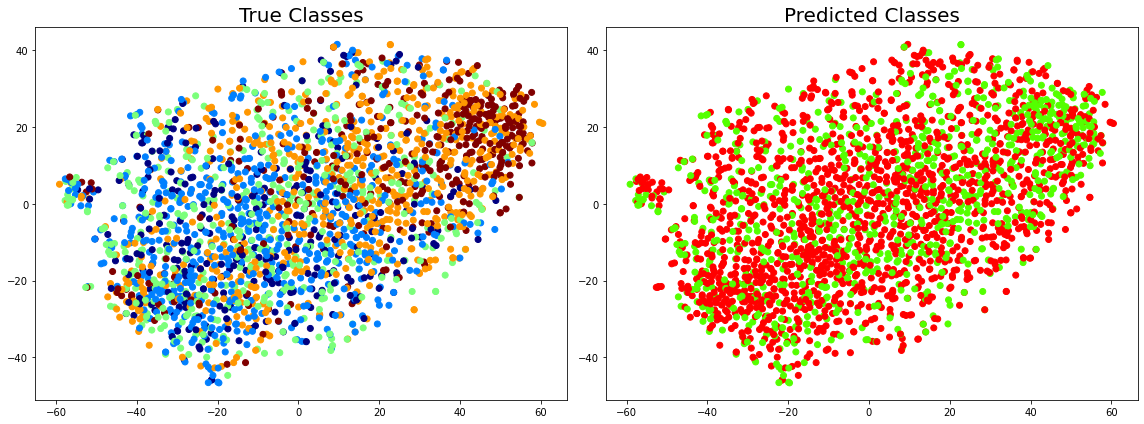

In [46]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

axes[0].scatter(projected_vectors[:, 0], projected_vectors[:, 1], c=_y_test, 
                cmap=plt.cm.get_cmap("jet", np.max(_y_test)+1))
axes[0].set_title("True Classes", fontsize=20)

axes[1].scatter(projected_vectors[:, 0], projected_vectors[:, 1], c=tester,
                cmap=plt.cm.get_cmap("prism", np.max(tester)+1))

axes[1].set_title("Predicted Classes", fontsize=20)


fig.tight_layout()
plt.show()

I think that _hidden_test is not good enough representation to allow to separate classes well. If the first plot would be good it would have already separated boundaries. I do not think that the model learned a good enough sentence representation to allow it reasonably well assess sentiment. All the points are very mixed with only few groupd sticking out a little bit more.